# Gaussian Process regression Hemocell analysis

In [1]:
import numpy as np
import pandas as pd

from lxml import etree

import matplotlib.pyplot as plt

from scipy.stats import norm,truncnorm,uniform,multivariate_normal

from SALib.sample import saltelli
from SALib.analyze import sobol

import tqdm

from sklearn.neighbors.kde import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,WhiteKernel

import statsmodels.api as sm

import UQLib.calibration.TMCMC as TMCMC

from local_config import *

titlefontsize = 24
axisfontsize = 24
labelfontsize = 20

plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Seed used for Master Thesis
np.random.seed(6345789)

In [2]:
names = {"kLink":r"$\kappa_l$","kBend":r"$\kappa_b$",
         "viscosityRatio":r"$\Lambda$","err":r"$\sigma^m$",
         "shearrate":r"$\dot{\gamma}$"}

## Load training data

In [3]:
# Load simulation data
mode="visc"

imin = 0
imax = 10

# Load simulation data
x_train = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y_train = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
c_err = np.load("%s/train_hemocell_c_err_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

x_fail = x_train[y_train[:,0] < 0,:-3]

# Remove failed simulation outputs
x_train = x_train[y_train[:,0] >= 0,:-3]
c_err = c_err[y_train[:,0] >= 0]
y_train = y_train[y_train[:,0] >= 0]

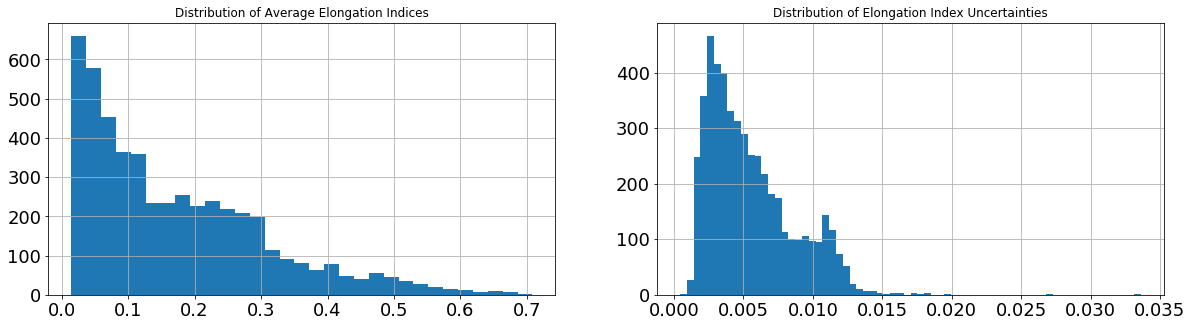

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.grid(True)
plt.hist(y_train,bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.grid(True)
plt.hist(c_err,bins='auto')
plt.show()

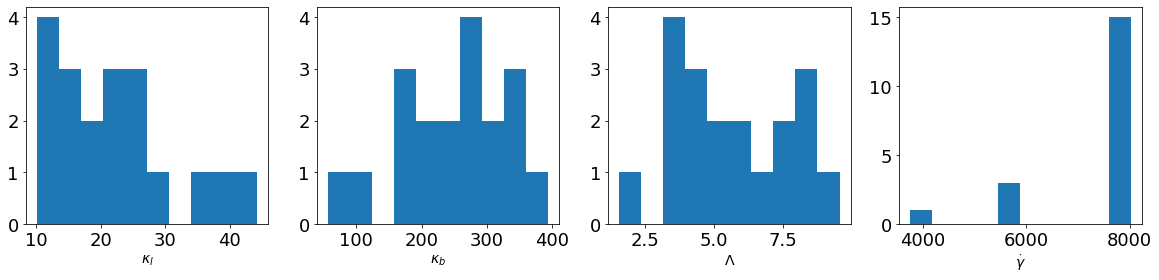

[[1.04376184e+01 3.40380112e+02 3.73208103e+00 3.76053215e+03]
 [1.39042694e+01 2.94625541e+02 7.30811798e+00 5.49002217e+03]
 [2.31973826e+01 1.63810966e+02 3.38292797e+00 5.49002217e+03]
 [2.23744680e+01 5.62990190e+01 4.83929383e+00 5.49002217e+03]
 [3.45660501e+01 2.63656543e+02 3.79682998e+00 8.01773836e+03]
 [1.83900561e+01 2.88338784e+02 6.72501492e+00 8.01773836e+03]
 [2.57752660e+01 2.97697905e+02 8.35316019e+00 8.01773836e+03]
 [1.18441405e+01 2.68337524e+02 5.17894894e+00 8.01773836e+03]
 [1.80835418e+01 3.55916214e+02 4.52639444e+00 8.01773836e+03]
 [1.39079445e+01 1.81466726e+02 1.56982462e+00 8.01773836e+03]
 [2.10134854e+01 2.50621915e+02 6.10036263e+00 8.01773836e+03]
 [4.42884862e+01 3.50236850e+02 4.26866290e+00 8.01773836e+03]
 [2.38810157e+01 1.75394634e+02 6.25203931e+00 8.01773836e+03]
 [2.69631770e+01 2.22090553e+02 3.69226897e+00 8.01773836e+03]
 [1.58792869e+01 2.41985919e+02 8.07443625e+00 8.01773836e+03]
 [1.24274551e+01 3.94301693e+02 9.56855639e+00 8.017738

In [5]:
plt.figure(figsize=(20,4))

params = ["kLink","kBend","viscosityRatio","shearrate"]
for n in range(x_fail.shape[1]):
    plt.subplot(1,4,n+1)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(x_fail[:,n])

plt.show()

print(x_fail)

## Train prediction model

In [6]:
def singleModel(x_train,y_train,n_restarts=0):
    kernel = RBF() + WhiteKernel()
    return GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts).fit(x_train,y_train)

def multipleModels(x_train,y_train,n_restarts=0):
    params,shearrates = x_train[:,:-1],x_train[:,-1]
    
    kernels = {shearrate : RBF() + WhiteKernel() for shearrate in np.unique(shearrates)}
    
    predictionModels = {}
    for shearrate in np.unique(shearrates):
        model = GaussianProcessRegressor(kernel=kernels[shearrate],
                                         n_restarts_optimizer=n_restarts).fit(params[shearrate == shearrates],
                                                                              y_train[shearrate == shearrates])
        
        predictionModels[shearrate] = model
        
    return predictionModels
    
# Train prediction model
model = multipleModels(x_train,y_train,n_restarts=10)

In [7]:
def predictionModel(x,return_std=False):
    if type(model) is dict:
        return model[x[0,-1]].predict(x[:,:-1],return_std=return_std)
    else:
        return model.predict(x,return_std=return_std)

## Test prediction model

In [8]:
imin = 2
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

model_params = ["kLink","kBend","viscosityRatio"]

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,1000,calc_second_order=False)
sobol_qoi = np.load("%s/sobol_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

idx_fail = np.where(sobol_qoi < 0)
idx_success = np.where(sobol_qoi >= 0)

x_fail = np.column_stack([param_values[idx_fail[0]],shearrate[idx_fail[1]]])
x_success = np.column_stack([param_values[idx_success[0]],shearrate[idx_success[1]]])

In [9]:
sobol_predictions = np.empty(sobol_qoi[idx_success].shape)

with tqdm.tqdm(total=sobol_predictions.size) as pbar:
    for n in range(sobol_predictions.size):
        sobol_predictions[n] = predictionModel(x_success[n][None,:])
        pbar.update()

S_err = np.sum((sobol_qoi[idx_success] - sobol_predictions)**2)
S_test = np.sum((np.mean(sobol_qoi[idx_success]) - sobol_qoi[idx_success])**2)

Q2 = 1 - S_err / S_test

print("Predictivity coefficient:",Q2)

100%|██████████| 39816/39816 [00:09<00:00, 4108.23it/s]


Predictivity coefficient: 0.9976394063206563


## Test performance of metamodel

In [10]:
test_params = np.column_stack([np.tile(np.array([120,80,5])[None,:],(shearrate.size,1)),shearrate])

In [11]:
for n in range(shearrate.size):
    print("Shear stress: %f, Shear rate: %f" % (stress[n],shearrate[n]))
    %timeit -n 1000 -r 100 predictionModel(test_params[n][None,:],return_std=True)

Shear stress: 0.640000, Shear rate: 567.627494
405 µs ± 110 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 0.930000, Shear rate: 824.833703
409 µs ± 116 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 1.360000, Shear rate: 1206.208426
380 µs ± 90.6 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 1.990000, Shear rate: 1764.966741
387 µs ± 89.7 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 2.910000, Shear rate: 2580.931264
386 µs ± 104 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 4.240000, Shear rate: 3760.532151
405 µs ± 100 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 6.190000, Shear rate: 5490.022173
402 µs ± 106 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)
Shear stress: 9.040000, Shear rate: 8017.738359
The slowest run took 5.09 times longer than the fastest. This could mean that an intermediate result is b

## Sentivity Analysis

In [12]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress = data.values[imin:imax,1]

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [13]:
n_samples = 10000

model_params = ["kLink","kBend","viscosityRatio"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,n_samples,calc_second_order=False)

sobol_qoi = np.zeros((param_values.shape[0],shearrate.size))

with tqdm.tqdm(total=sobol_qoi.size) as pbar:
    for n,param_set in enumerate(param_values):
        for m,design_val in enumerate(shearrate):
            arr = np.array([*param_values[n],design_val])[None,:]
            mean = predictionModel(arr)

            sobol_qoi[n,m] = mean
            
            pbar.update()

100%|██████████| 500000/500000 [01:57<00:00, 4239.81it/s]


In [14]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

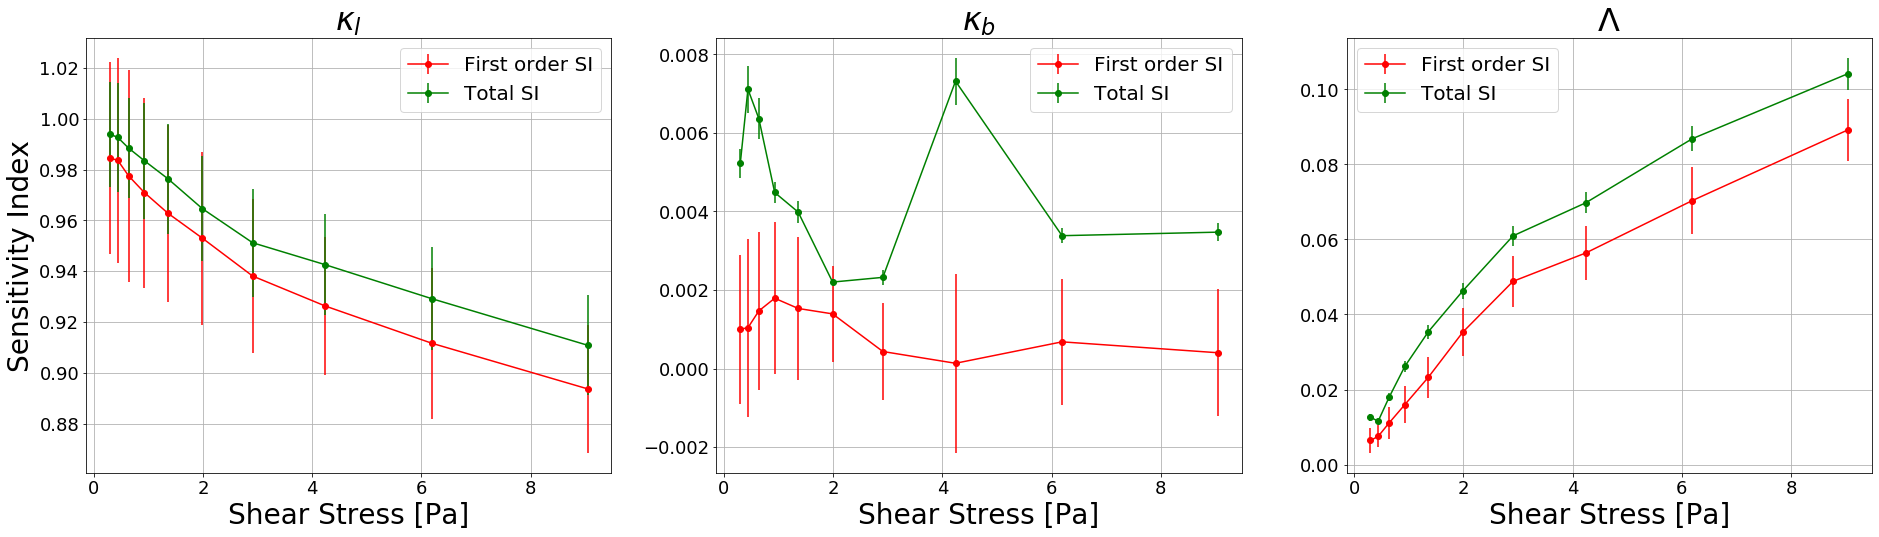

In [15]:
plt.figure(figsize=(32,8))
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(names[model_params[n]],fontsize=32)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=28)
    
    if n == 0:
        plt.ylabel("Sensitivity Index",fontsize=28)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],color="red",fmt="o-",label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],color="green",fmt="o-",label="Total SI")
    
    plt.legend(fontsize=labelfontsize)

plt.show()

## Setup TMCMC sampling

In [44]:
def evaluate_GP(params):
    kLink = params["kLink"]
    kBend = params["kBend"]
    viscosityRatio = params["viscosityRatio"]
    shearrate = params["shearrate"]
    
    arr = np.array([kLink,kBend,viscosityRatio,shearrate])[None,:]
    mean,std = predictionModel(arr,return_std=True)
    return mean[0],std[0]

def model_prior(sample,enableInteriorViscosity):
    kLink_prior = uniform.pdf(sample[0],10.0,290.0)
    kBend_prior = uniform.pdf(sample[1],50.0,350.0)
    
    if enableInteriorViscosity:
        viscosityRatio_prior = uniform.pdf(sample[2],1.0,14.0)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler(n_samples,enableInteriorViscosity):
    kLink_samples = np.random.uniform(10.0,300.0,n_samples)
    kBend_samples = np.random.uniform(50.0,400.0,n_samples)
    
    if enableInteriorViscosity:
        viscosityRatio_samples = np.random.uniform(1.0,15.0,n_samples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])

def model_prior_gaussian(sample,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_prior = truncnorm.pdf(sample[0],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    a,b,mean,std = 50,400,320,100
    kBend_prior = truncnorm.pdf(sample[1],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_prior = truncnorm.pdf(sample[2],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler_gaussian(n_samples,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
    
    a,b,mean,std = 50,400,320,100
    kBend_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])
    
def error_prior(sample):
    return np.prod(uniform.pdf(sample,0.001,0.099))

def error_sampler(n_samples):
    return np.random.uniform(0.001,0.1,(n_samples,1))

## Sanity Check

### Healthy

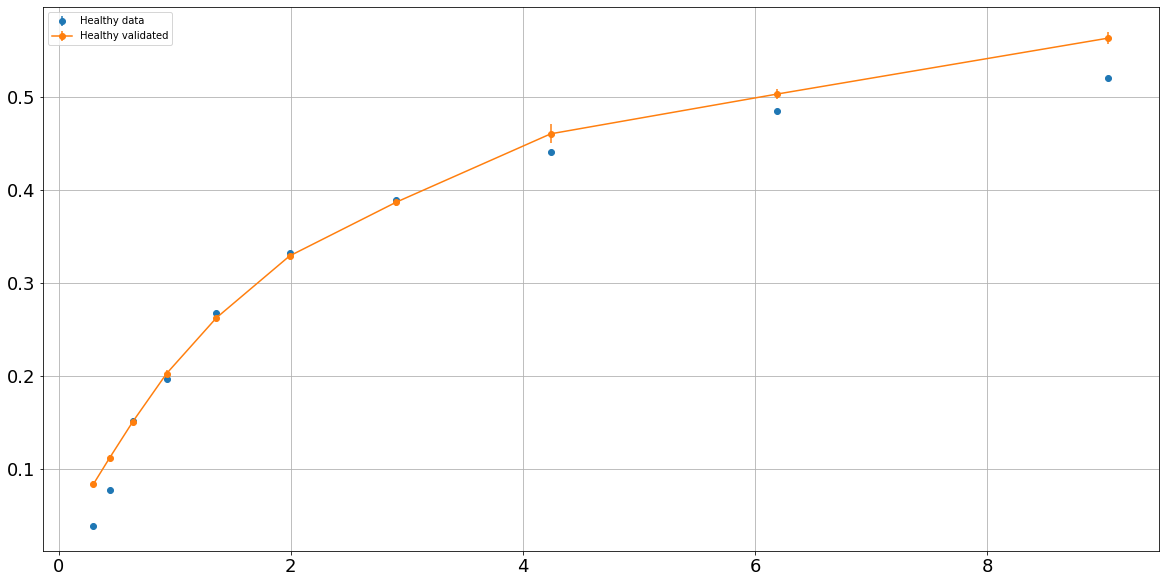

In [45]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el = data.values[imin:imax,[1,2]].T

el_err = np.zeros(stress.shape)

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

healthy_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

healthy_samples[:,:-1] = np.array([40,250,5])
healthy_samples[:,-1] = shearrate

healthy_qoi = np.empty(shearrate.shape[0])
healthy_std = np.empty(shearrate.shape[0])
for n in range(healthy_qoi.size):
    healthy_qoi[n],healthy_std[n] = predictionModel(healthy_samples[n][None,:],return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Healthy data")
plt.errorbar(stress,healthy_qoi,yerr=healthy_std,fmt='o-',label="Healthy validated")

plt.grid(True)
plt.legend()

plt.show()

### Treated

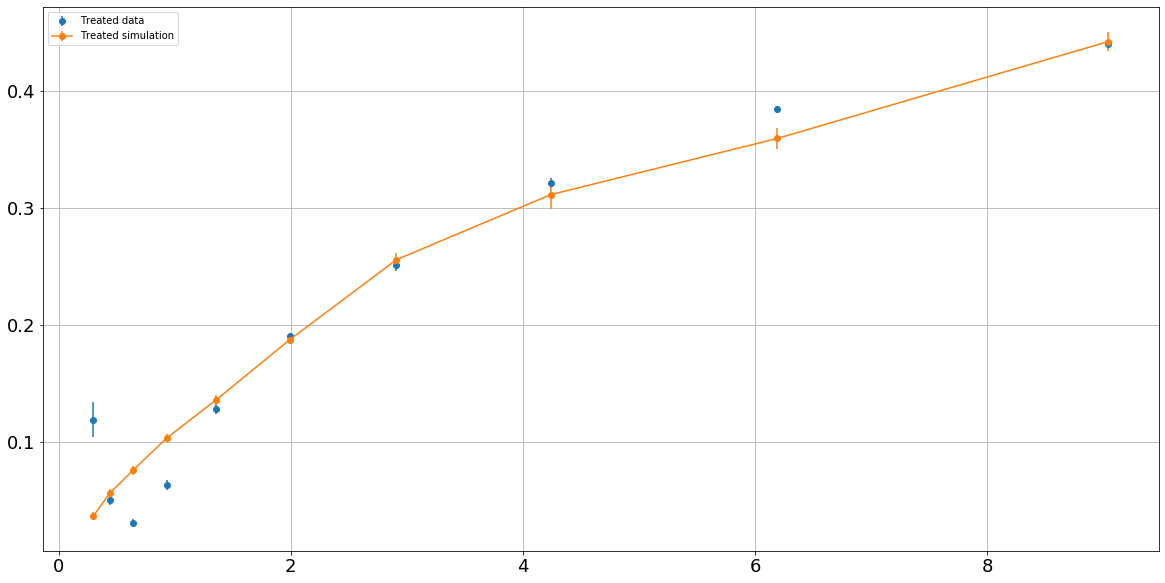

In [46]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

treated_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

treated_samples[:,:-1] = np.array([110,395,3.5])
treated_samples[:,-1] = shearrate

treated_qoi = np.empty(shearrate.shape[0])
treated_std = np.empty(shearrate.shape[0])
for n in range(treated_qoi.size):
    treated_qoi[n],treated_std[n] = predictionModel(treated_samples[n][None,:],return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Treated data")
plt.errorbar(stress,treated_qoi,yerr=treated_std,fmt='o-',label="Treated simulation")

plt.grid(True)
plt.legend()

plt.show()

## TMCMC sampling

In [47]:
method = "TMCMC"
lmax = 1
nburn = 20
cellHealth = "healthy"

if cellHealth == "healthy":
    imin = 2
    imax = 10
elif cellHealth == "treated":
    imin = 4
    imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]

if cellHealth == "healthy":
    stress,el = data.values[imin:imax,[1,2]].T
    el_err = np.zeros(stress.shape)
elif cellHealth == "treated":
    stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

print(data)

    Treatment  Stress (pa)  EL Healthy  EL 100%  EL error (+/-)
45        0.5         0.30       0.038    0.119           0.015
46        0.5         0.44       0.077    0.050           0.004
47        0.5         0.64       0.151    0.031           0.003
48        0.5         0.93       0.196    0.063           0.004
49        0.5         1.36       0.268    0.128           0.004
50        0.5         1.99       0.332    0.190           0.003
51        0.5         2.91       0.389    0.251           0.005
52        0.5         4.24       0.441    0.321           0.004
53        0.5         6.19       0.485    0.384           0.003
54        0.5         9.04       0.521    0.440           0.003
55        0.5        13.20       0.549    0.487           0.002
56        0.5        19.28       0.576    0.523           0.004
57        0.5        28.15       0.598    0.554           0.002
58        0.5        41.10       0.620    0.581           0.002
59        0.5        60.00       0.639  

In [48]:
np.random.seed(7773777)

n_samples = 10000

model_params = ["kLink","kBend","viscosityRatio"]
error_params = ["err"]
design_vars = ["shearrate"]

# Full parameter set
params = model_params + error_params

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Map model errors to data samples
error_mapping = ["err" for n in range(shearrate.shape[0])]

# Construct problem dict
problem = {"model_type":"python",
           "evaluate":evaluate_GP,
           "model_params":model_params,
           "error_params":error_params,
           "design_vars":design_vars,
           "input_data":shearrate,
           "output_data":el,
           "data_errors":el_err,
           "error_mapping":error_mapping,
           "model_prior":(lambda sample: model_prior(sample,1)),
           "model_sampler":(lambda n_samples: model_sampler(n_samples,1)),
           "error_prior":error_prior,
           "error_sampler":error_sampler
          }

# Run Inverse UQ
TMCMC_sampler = TMCMC.TMCMC(problem,lmax=lmax,nburn=nburn,logpath=None,logstep=1e6)
df,qoi,c_err = TMCMC_sampler.sample(n_samples)

print(df)

Initializing...


100%|██████████| 10000/10000 [01:03<00:00, 200.05it/s]


Current max likelihood: 145342627114.8032
Calculating p for stage 1...
p: 0.0038522730070685626
COV: 0.9999999991619636
Running stage 1...
Maximum chain length: 1


100%|██████████| 210000/210000 [24:44<00:00, 141.42it/s]


Current max likelihood: 318492489716.11926
Calculating p for stage 2...
p: 0.018895403011816227
COV: 1.0000000017167305
Running stage 2...
Maximum chain length: 1


100%|██████████| 210000/210000 [25:00<00:00, 144.35it/s]


Current max likelihood: 395200741276.5659
Calculating p for stage 3...
p: 0.09166091696679289
COV: 0.9999999997586201
Running stage 3...
Maximum chain length: 1


100%|██████████| 210000/210000 [25:15<00:00, 138.57it/s]


Current max likelihood: 320808704355.1631
Calculating p for stage 4...
p: 0.34531505717081257
COV: 0.9999999882039082
Running stage 4...
Maximum chain length: 1


100%|██████████| 210000/210000 [25:32<00:00, 137.04it/s]


Current max likelihood: 700185904838.882
Calculating p for stage 5...
p: 0.7067961803728332
COV: 0.9999999959133902
Running stage 5...
Maximum chain length: 1


100%|██████████| 210000/210000 [26:26<00:00, 132.36it/s]


Current max likelihood: 779867358402.6646
Calculating p for stage 6...
p: 1.0
COV: 0.6391261501080029
Running stage 6...
Maximum chain length: 1


100%|██████████| 210000/210000 [32:21<00:00, 108.17it/s]


Current max likelihood: 798765774205.9071
Sampling finished :)
          kLink       kBend  viscosityRatio       err    likelihood     prior
0     37.998524  104.989204        6.111257  0.060521  2.802505e+08  0.000007
1     41.474552  159.197844        6.687697  0.046144  1.615160e+09  0.000007
2     37.220311  356.860134        6.965434  0.066935  3.041267e+09  0.000007
3     40.556690  342.058305        5.524280  0.043857  8.568209e+09  0.000007
4     34.994676  345.160944        8.301046  0.089283  4.807350e+08  0.000007
...         ...         ...             ...       ...           ...       ...
9995  29.518032  327.373213       13.404013  0.097203  1.763224e+08  0.000007
9996  35.912643  378.714165        5.789866  0.040070  7.692978e+10  0.000007
9997  37.370102  353.759616        5.495540  0.018373  1.042257e+11  0.000007
9998  35.926818  336.526137        6.302617  0.030443  9.295930e+10  0.000007
9999  36.680428  357.726488        5.883383  0.026661  5.262211e+11  0.000007



In [49]:
# Save output
df.to_csv("%s/%s_GP_%s_samples_visc_%i_%i_lmax_%s_nburn_%i.csv" % 
          (outputpath,method,cellHealth,imin,imax,lmax,nburn),sep=";",index=False)

np.save("%s/%s_GP_%s_qoi_visc_%i_%i_lmax_%s_nburn_%i.npy" % 
        (outputpath,method,cellHealth,imin,imax,lmax,nburn),qoi)

np.save("%s/%s_GP_%s_c_err_visc_%i_%i_lmax_%s_nburn_%i.npy" % 
        (outputpath,method,cellHealth,imin,imax,lmax,nburn),c_err)

## Analyze results

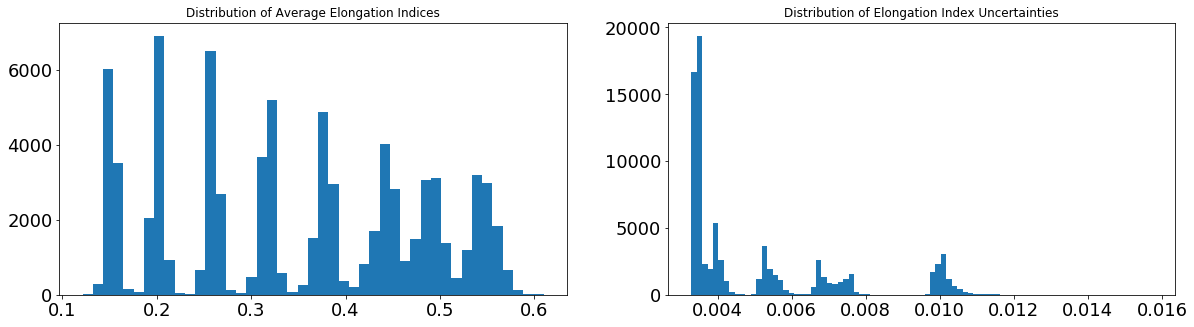

In [50]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.hist(qoi.flatten(),bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.hist(c_err.flatten(),bins='auto')
plt.show()

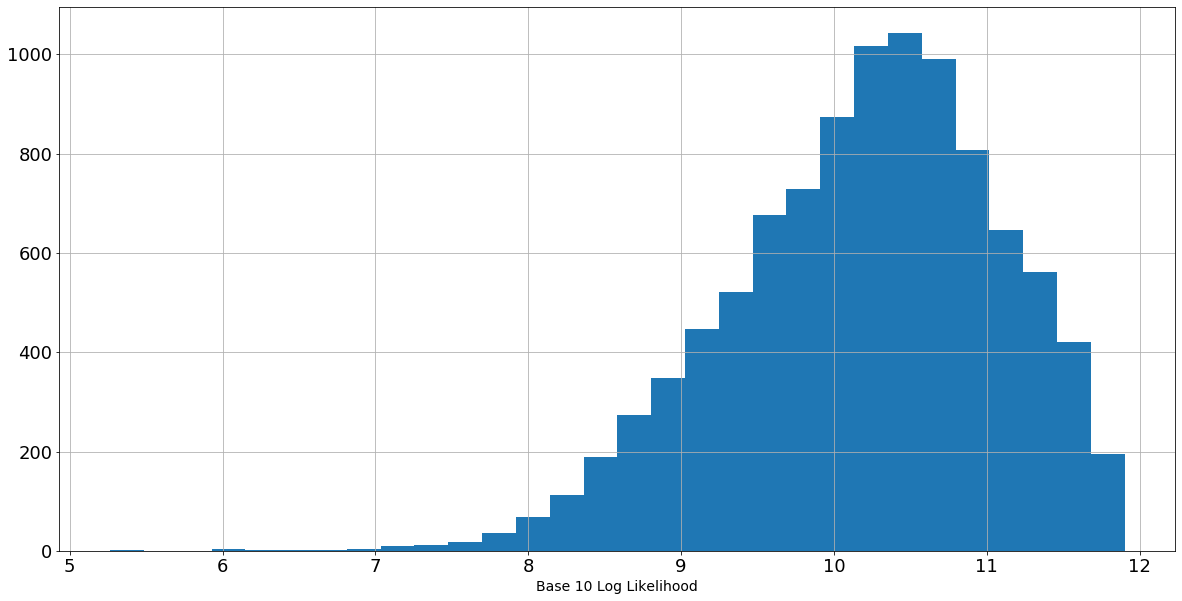

In [51]:
nbins = 30
plt.figure(figsize=(20,10))
plt.grid(True)

if method == "TMCMC":
    plt.xlabel(r"Base 10 Log Likelihood",fontsize=14)
    plt.hist(np.log10(df["likelihood"].values),bins=nbins)
    
plt.show()

In [52]:
if method == "TMCMC":
    for n in range(-10,16):
        print("Number of high densities larger than %e:" % (10**n),np.sum(df["likelihood"].values > 10**n))

Number of high densities larger than 1.000000e-10: 10000
Number of high densities larger than 1.000000e-09: 10000
Number of high densities larger than 1.000000e-08: 10000
Number of high densities larger than 1.000000e-07: 10000
Number of high densities larger than 1.000000e-06: 10000
Number of high densities larger than 1.000000e-05: 10000
Number of high densities larger than 1.000000e-04: 10000
Number of high densities larger than 1.000000e-03: 10000
Number of high densities larger than 1.000000e-02: 10000
Number of high densities larger than 1.000000e-01: 10000
Number of high densities larger than 1.000000e+00: 10000
Number of high densities larger than 1.000000e+01: 10000
Number of high densities larger than 1.000000e+02: 10000
Number of high densities larger than 1.000000e+03: 10000
Number of high densities larger than 1.000000e+04: 10000
Number of high densities larger than 1.000000e+05: 10000
Number of high densities larger than 1.000000e+06: 9998
Number of high densities larger 

Best sample:
kLink             3.658676e+01
kBend             3.655038e+02
viscosityRatio    5.965174e+00
err               2.329969e-02
likelihood        7.987658e+11
prior             7.108381e-06
Name: 5561, dtype: float64


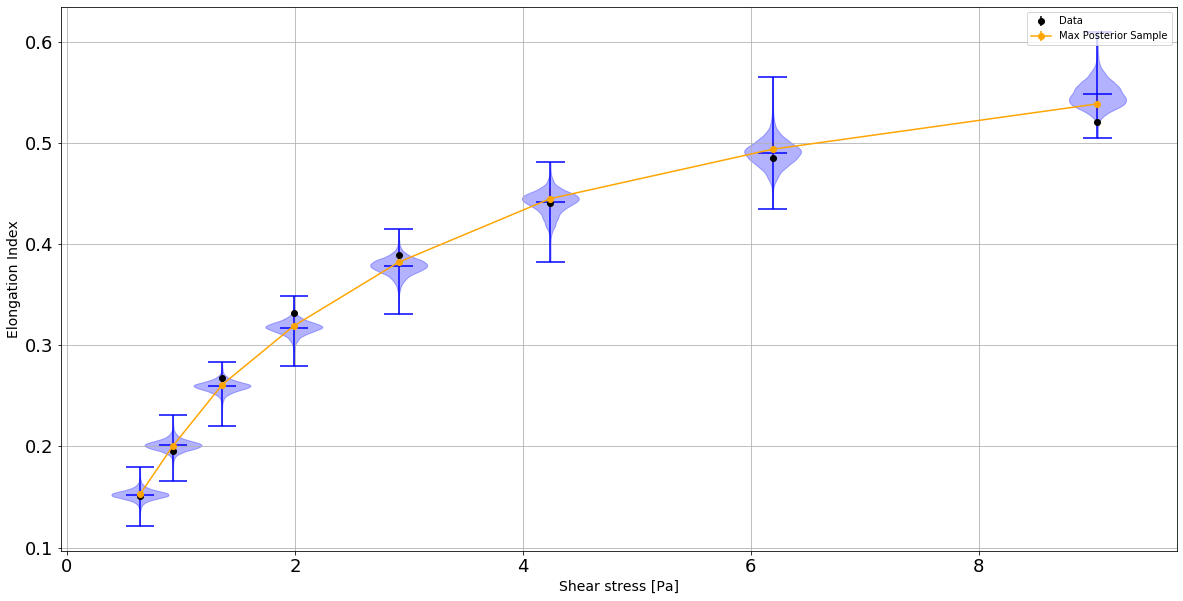

In [53]:
violin_color = "blue"
mpe_color = "orange"
data_color = "black"

plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",color=data_color,label="Data")

# Highest likelihood
if method == "TMCMC":
    mle = np.argmax(df["likelihood"].values)
    mpe = np.argmax(df["likelihood"].values * df["prior"].values)
    #print("Max likelihood:",sample_df["likelihood"].values[mle])
elif method == "ABCSubSim":
    mle = np.argmin(df["distance"].values)
    #print("Minimum distance:",sample_df["distance"].values[mle])

print("Best sample:")
print(df.loc[mpe])
    
#plt.errorbar(stress,qoi[mle],c_err[mle],fmt="o-",label="Max Likelihood Sample")
plt.errorbar(stress,qoi[mpe],c_err[mpe],fmt="o-",color=mpe_color,label="Max Posterior Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

ptile = np.percentile(qoi,[2.5,97.5],axis=0)

ptile[0] = mean - ptile[0]
ptile[1] -= mean

#plt.errorbar(stress,mean,yerr=ptile,fmt="o-",label="Mean QoI")

violin_parts = plt.violinplot(qoi,stress,showmeans=True)

for partname in ['cbars','cmins','cmaxes','cmeans']:
    vp = violin_parts[partname]
    vp.set_edgecolor(violin_color)

for vp in violin_parts["bodies"]:
    vp.set_facecolor(violin_color)
    vp.set_edgecolor(violin_color)

plt.legend()
plt.show()

In [54]:
"""
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Plot all qoi
for n in range(qoi.shape[0]):
    plt.plot(stress,qoi[n])

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
plt.legend()

plt.show()
"""

'\nplt.figure(figsize=(20,10))\nplt.xlabel("Shear stress [Pa]",fontsize=14)\nplt.ylabel("Elongation Index",fontsize=14)\n\nplt.grid(True)\n\n# Plot all qoi\nfor n in range(qoi.shape[0]):\n    plt.plot(stress,qoi[n])\n\n# Data\nplt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")\n    \nplt.legend()\n\nplt.show()\n'

## Parameter distributions in 1D

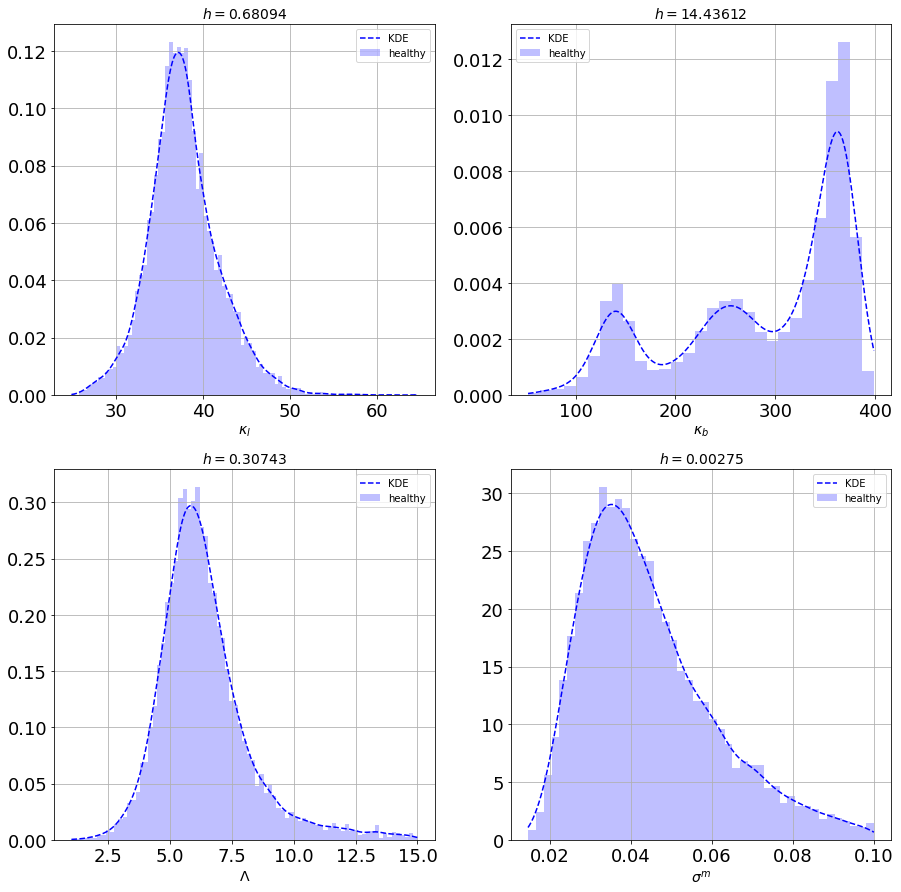

In [55]:
color = "blue"

plt.figure(figsize=(15,15))
for n in range(len(params)):
    vals = df[params[n]].values
    
    kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="c",bw="normal_reference")
    
    x_vals = np.linspace(np.min(vals),np.max(vals),1000)
    y_vals = kde.pdf(x_vals)
    
    plt.subplot(2,2,n+1)
    plt.title(r"$h = %.5f$" % kde.bw,fontsize=14)
    plt.grid(True)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(df[params[n]].values,color=color,bins="auto",density=True,alpha=0.25,label=cellHealth)
    plt.plot(x_vals,y_vals,'--',color=color,label="KDE")
    plt.legend()
    
plt.show()

## Plot parameters in 2D

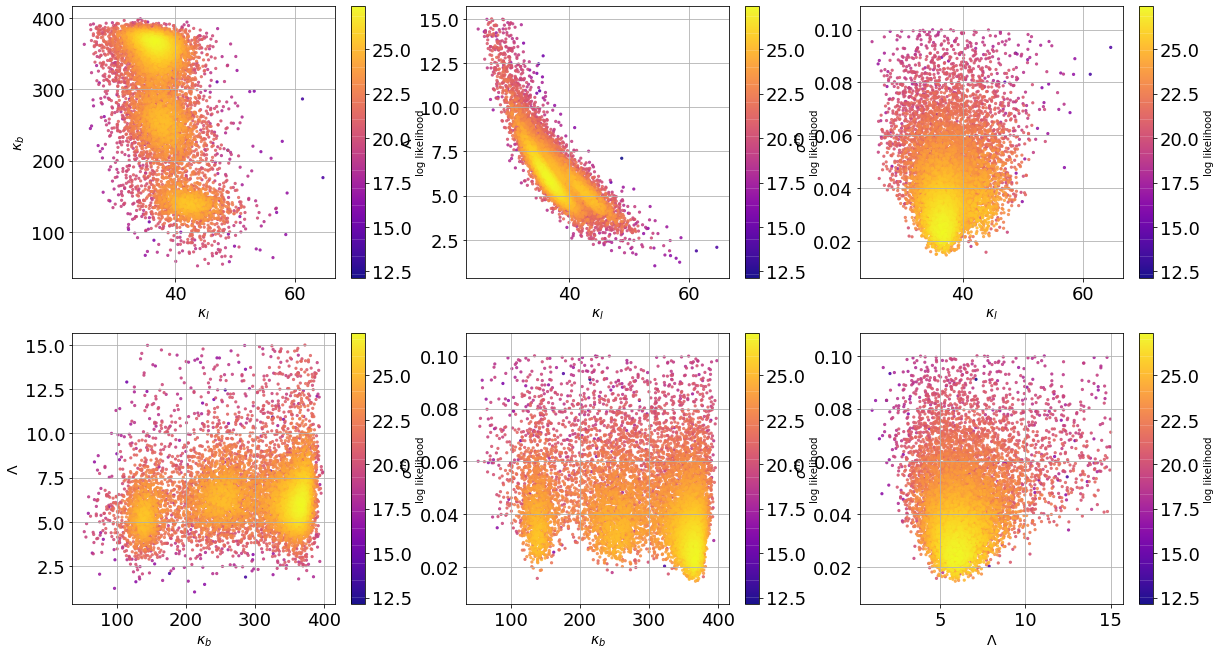

In [56]:
plt.figure(figsize=(20,11))

count = 1
s=5
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            plt.subplot(2,3,count)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            if method == "TMCMC":
                order = np.argsort(df["likelihood"])
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=np.log(df["likelihood"].values[order]),cmap="plasma",alpha=0.8)
                
            elif method == "ABCSubSim":
                order = np.argsort(df["distance"])[::-1]
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=df["distance"].values[order],cmap="inferno")
                
            plt.colorbar(label="log likelihood")
            count += 1

plt.show()

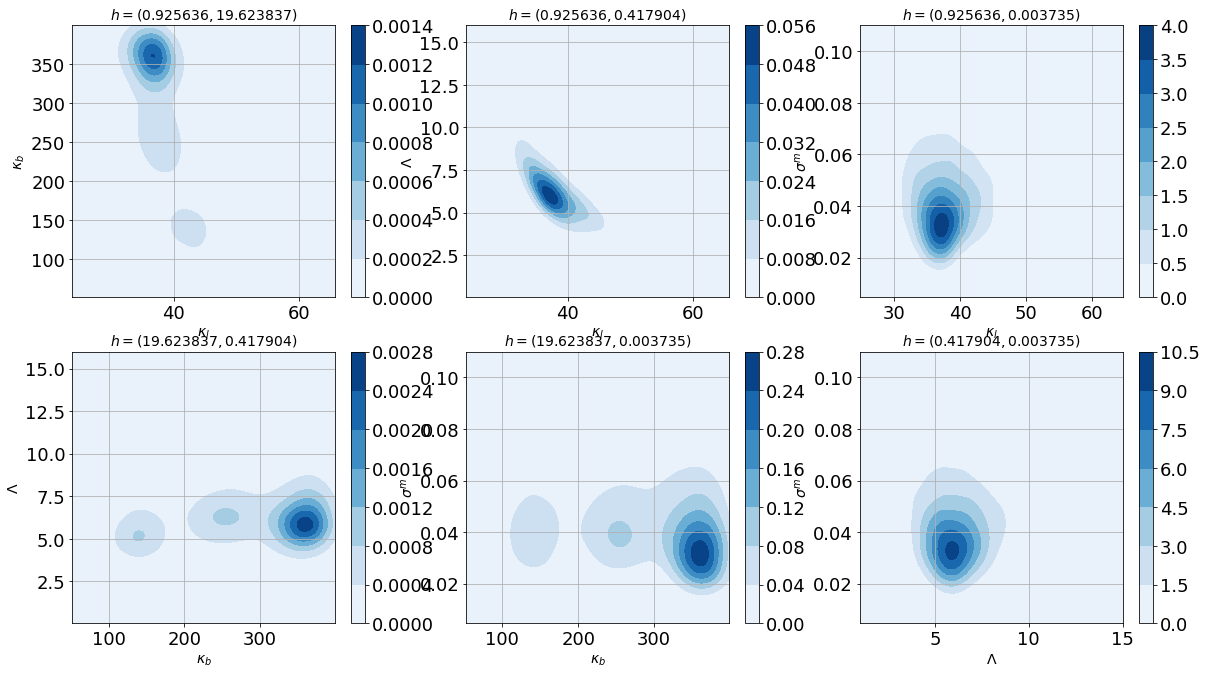

In [57]:
cmap = "Blues"

plt.figure(figsize=(20,11))

zoom = [1.0,1.0,0.01,
        1.0,0.01,0.01]

count = 1
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            vals = df[[params[n],params[m]]].values
            
            kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="cc",bw="normal_reference")
            
            x = np.linspace(np.min(vals[:,0])-zoom[count-1],np.max(vals[:,0])+zoom[count-1],100)
            y = np.linspace(np.min(vals[:,1])-zoom[count-1],np.max(vals[:,1])+zoom[count-1],100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            grid_vals = kde.pdf(grid_flat).reshape(xx.shape)
            
            plt.subplot(2,3,count)
            plt.title(r"$h = (%f,%f)$" % tuple(kde.bw),fontsize=14)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            plt.contourf(xx,yy,grid_vals,cmap=cmap)
            plt.colorbar()
            count += 1

plt.show()